In [46]:
import numpy as np

from astropy import units as u

from astropy.coordinates import SkyCoord, Angle
from astropy.table import Table
from astropy.wcs import WCS
from astropy.visualization import LogStretch, MinMaxInterval, ManualInterval
from astropy import modeling
from astropy import constants as cnst

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams, style
rcParams['image.cmap'] = 'viridis'
rcParams['image.origin'] = 'lower'
rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']

In [3]:
# a fun trick that makes the notebook always be 90% of the browser window
from IPython.core.display import HTML
HTML("<style>.container { width:90% !important; }</style>")

# Load relevant data 

In [4]:
import data_loaders

In [5]:
res = data_loaders.load_galfa_sensitivity('onempc_mass_sens.fits.zip')
galfa_sens, galfa_sens_scs, galfa_sens_wcs, galfa_sens_hdu = res

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):


# Fiducial sensitivity senario for FAST


* 7e3 solar masses of HI at 1 Mpc / sqrt(cos(dec)) from 0 to 53 degrees
* 1e4 solar masses of HI at 1 Mpc / sqrt(cos(dec)) from -14 to 0 degrees
* 1e4 solar masses of HI at 1 Mpc / sqrt(cos(dec)) from 53 to 66 degrees


## Create a WCS approprate for FAST 

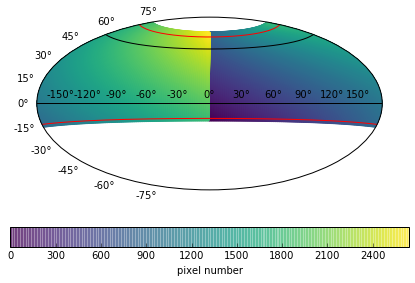

In [6]:
wcs = WCS(dict(WCSAXES=2, 
               CRPIX1=0, CRPIX2=0, 
               CDELT1=0.2, CDELT2=0.1, 
               CTYPE1='RA', CTYPE2='DEC', 
               CUNIT1='deg', CUNIT2='deg',
               CRVAL1=0., CRVAL2=-15.0,
               LONPOLE=0., LATPOLE=90.,
               RADESYS='FK5', EQUINOX=2000))

xg, yg = np.mgrid[:1800,:850]
ra_g, dec_g = Angle(wcs.wcs_pix2world(xg ,yg, 0), u.deg)

plt.subplot(projection='hammer')
ptmsk = slice(None, None, 10)
plt.scatter(ra_g.wrap_at(180*u.deg).rad[ptmsk], dec_g.rad[ptmsk], c = (xg+yg)[ptmsk], lw=0, alpha=.5)
plt.colorbar(orientation='horizontal').set_label('pixel number')

# the FAST zone edges
lon_all = np.linspace(-np.pi, np.pi, 100)
plt.plot(lon_all, [66*u.deg.to(u.rad)]*len(lon_all), c='r')
plt.plot(lon_all, [53*u.deg.to(u.rad)]*len(lon_all), c='k')
plt.plot(lon_all, [0*u.deg.to(u.rad)]*len(lon_all), c='k')
plt.plot(lon_all, [-14*u.deg.to(u.rad)]*len(lon_all), c='r')

plt.tight_layout()

## Now generate the sensitivity map

In [7]:
outermsk = (-14<dec_g.deg)&(dec_g.deg<66)
innermsk = (0<dec_g.deg)&(dec_g.deg<53)

sens = np.zeros(dec_g.shape)
sens[outermsk] = 1e4 * np.cos(dec_g[outermsk]).value**-0.5
sens[innermsk] = 7e3 * np.cos(dec_g[innermsk]).value**-0.5

sens = sens*u.solMass * u.Mpc**-2

### And plot it like for GALFA

In [8]:
galfa_min, galfa_max = 0, 5e5
galfa_stretch = LogStretch() + ManualInterval(galfa_min, galfa_max)
galfa_minst, galfa_maxst = galfa_stretch([galfa_min, galfa_max])

def show_sens(sens_arr, name=None, fig=None):
    if fig is None:
        fig = plt.figure(figsize=(20,6))
    else:
        plt.figure(fig)
    plt.imshow(galfa_stretch(sens_arr.value.T), vmin=galfa_minst, vmax=galfa_maxst)
    if name is not None:
        plt.title(name, fontsize=24)
    plt.xlabel('RA arcmin', fontsize=24)
    plt.ylabel('Dec arcmin', fontsize=24)
    cb = plt.colorbar(orientation='horizontal')
    cb.set_label('Log Sensitivity ({})'.format(sens_arr.unit.to_string('latex')), fontsize=24)
    ticklocs = cb.formatter.locs
    tickdata = galfa_stretch.transform_2.inverse(cb.formatter.locs)*galfa_stretch.transform_1.vmax + galfa_stretch.transform_1.vmin
    cb.set_ticks(ticklocs)
    cb.set_ticklabels(['{:.1f}'.format(np.log10(d)) for d in tickdata])

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log10


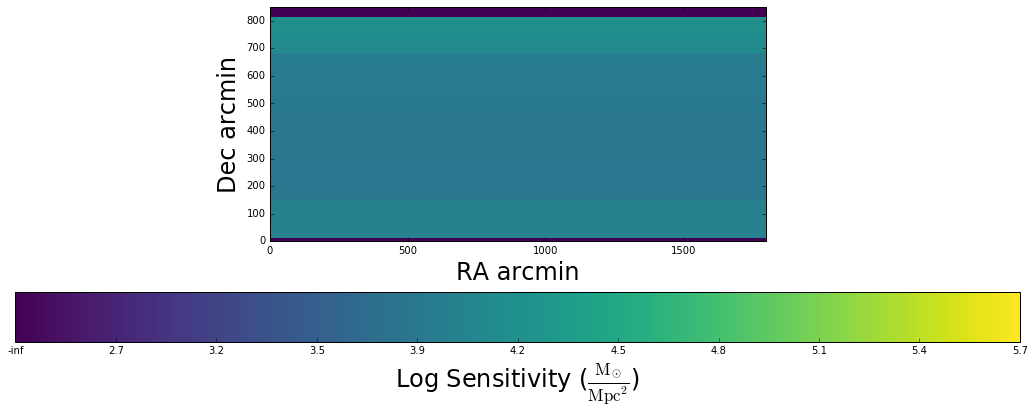

In [9]:
show_sens(sens)

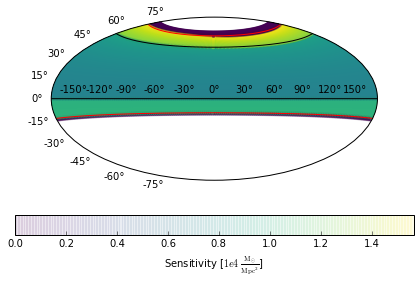

In [10]:
plt.subplot(projection='hammer')
ptmsk = slice(None, None, 10)
plt.scatter(ra_g.wrap_at(180*u.deg).rad[ptmsk], dec_g.rad[ptmsk], c = sens[ptmsk]/1e4, lw=0, alpha=.1)
plt.colorbar(orientation='horizontal').set_label('Sensitivity [$1e4$ {}]'.format(sens.unit.to_string('latex')))

# the FAST zone edges
lon_all = np.linspace(-np.pi, np.pi, 100)
plt.plot(lon_all, [66*u.deg.to(u.rad)]*len(lon_all), c='r')
plt.plot(lon_all, [53*u.deg.to(u.rad)]*len(lon_all), c='k')
plt.plot(lon_all, [0*u.deg.to(u.rad)]*len(lon_all), c='k')
plt.plot(lon_all, [-14*u.deg.to(u.rad)]*len(lon_all), c='r')

plt.tight_layout()

# Now compute detectable halos given that sensitivity map

In [11]:
import data_loaders, detectability

In [12]:
elvii_pairs = data_loaders.load_elvii_z0(isolated=False)

Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Hall&Oates.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Hamilton&Burr.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Kek&Kauket.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Lincoln&Douglas.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Orion&Taurus.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Romulus&Remus.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Scylla&Charybdis.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Serena&Venus.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Siegfried&Roy.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Sonny&Cher.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Thelma&Louise.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Zeus&Hera.txt


In [13]:
elvii_trees = data_loaders.load_elvii_trees('ID,Mvir,Vmax,Rvir,upID,scale')

Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Hall&Oates
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Hamilton&Burr
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Kek&Kauket
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Lincoln&Douglas
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Orion&Taurus
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Romulus&Remus
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Scylla&Charybdis
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Serena&Venus
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Siegfried&Roy
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Sonny&Cher
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Thelma&Louise
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Zeus&Hera


/Users/erik/projects/m31-galfa/data_loaders.py:83: RuntimeWarning: divide by zero encountered in true_divide
  coldct['z'] = 1./coldct['scale'] - 1


In [14]:
data_loaders.annotate_z0_from_trees(elvii_pairs, elvii_trees)

In [15]:
#m31 = SkyCoord.from_name('M31')
m31 = SkyCoord(10.6847083*u.deg, 41.26875*u.deg, 700*u.kpc)

In [16]:
detectability.compute_elvis_mgas_bradford_15(elvii_pairs)

for tab in elvii_pairs.values():
    #these add host{n}_lat/host{n}_lon/host{n}_dist
    data_loaders.add_oriented_radecs(tab, 0, 1, target_coord=m31)
    data_loaders.add_oriented_radecs(tab, 1, 0, target_coord=m31)

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/units/quantity.py:763: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return super(Quantity, self).__eq__(other)


In [17]:
detectability.compute_elvis_detectability(sens, wcs, 'fast', elvii_pairs)

In [18]:
detectability.compute_elvis_detectability(galfa_sens, galfa_sens_wcs, 'galfadr1', elvii_pairs)

In [19]:
wakker_hvcs = Table.read('wakk.fits')
wakker_scs = SkyCoord(l=wakker_hvcs['L'], b=wakker_hvcs['B'], unit=u.deg, frame='galactic')

detectability.compute_elvis_findable(elvii_pairs, wakker_scs, wakker_hvcs['VLSR']*u.km/u.s)

## Produce a summary table

In [87]:
summary_tab = Table(names=['host name', 'nfast z0', 'ngalfa z0', 'nfast/galfa z0', 'nfast ever', 'ngalfa ever', 'nfast/galfa ever'], 
                    dtype=['S10', int, int, float, int, int, float])

for names in elvii_pairs:
    cat = elvii_pairs[names]
    ns = names.split('&')
    for i in (0, 1):
        findable_fast = cat['findable_fast_host'+str(i)]
        findable_galfa = cat['findable_galfadr1_host'+str(i)]
        
        nfast0 = np.sum(findable_fast&~cat['sat_of_either'])
        ngalfa0 = np.sum(findable_galfa&~cat['sat_of_either'])
        nfastever = np.sum(findable_fast&~cat['upIDever_either'])
        ngalfaever = np.sum(findable_galfa&~cat['upIDever_either'])
        summary_tab.add_row([ns[i], nfast0, ngalfa0, nfast0/ngalfa0, nfastever, ngalfaever, nfastever/ngalfaever])
        
summary_tab.show_in_notebook()

host name,nfast z0,ngalfa z0,nfast/galfa z0,nfast ever,ngalfa ever,nfast/galfa ever
Siegfried,148,36,4.11111111111,75,17,4.41176470588
Roy,154,29,5.31034482759,76,13,5.84615384615
Orion,36,10,3.6,16,3,5.33333333333
Taurus,80,14,5.71428571429,40,8,5.0
Kek,78,17,4.58823529412,32,10,3.2
Kauket,114,30,3.8,76,16,4.75
Romulus,61,9,6.77777777778,25,1,25.0
Remus,60,19,3.15789473684,24,6,4.0
Lincoln,75,26,2.88461538462,25,9,2.77777777778
Douglas,88,20,4.4,39,6,6.5


# now add in a reionization cut for Tvir @ z=6

In [53]:
# values from the "Probabilistic Experiments" notebook
lmvirtolrvir =  modeling.models.Linear1D(slope=0.3332146169115156, intercept=-1.4803268453825718)

vtoltvir = lambda v: np.log10((0.6 * cnst.m_p*v**2 / 2 / cnst.k_B)/u.K)
def lmtoltvir(lmvir):
    lrvir = lmvirtolrvir(lmvir)
    vsq = cnst.G * 10**lmvir/10**lrvir * (u.solMass/u.kpc)
    return np.log10((0.6 * cnst.m_p*vsq / 2 / cnst.k_B)/u.K)

In [78]:
for name, tree in elvii_trees.items():
    for z_re in (6,7,8,9):
        idxzre = np.argmin(np.abs(tree[0]['z']-z_re))    
        elvii_pairs[name]['Mviratz{}'.format(z_re)] = tree['Mvir'][:, idxzre]
        elvii_pairs[name]['Rviratz{}'.format(z_re)] = tree['Rvir'][:, idxzre]
        elvii_pairs[name]['Vmatz{}'.format(z_re)] = tree['Vmax'][:, idxzre]
        elvii_pairs[name]['Tviratz{}'.format(z_re)] = 10**lmtoltvir(np.log10(tree['Mvir'][:, idxzre]/u.solMass))*u.K

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/units/quantity.py:822: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__truediv__(other)


## Produce a summary table *including* the reionization cut

In [136]:
summary_tab_re = Table(names=['host name', 'nfast z0', 'ngalfa z0', 'nfast/galfa z0', 'nfast ever', 'ngalfa ever', 'nfast/galfa ever'], 
                    dtype=['S10', int, int, float, int, int, float])

for names in elvii_pairs:
    cat = elvii_pairs[names]
    ns = names.split('&')
    for i in (0, 1):
        tvirmsk = np.isfinite(cat['Tviratz8'])&(cat['Tviratz8']>10**3.*u.K)
        findable_fast = cat['findable_fast_host'+str(i)]&tvirmsk
        findable_galfa = cat['findable_galfadr1_host'+str(i)]&tvirmsk
        
        nfast0 = np.sum(findable_fast&~cat['sat_of_either'])
        ngalfa0 = np.sum(findable_galfa&~cat['sat_of_either'])
        nfastever = np.sum(findable_fast&~cat['upIDever_either'])
        ngalfaever = np.sum(findable_galfa&~cat['upIDever_either'])
        summary_tab_re.add_row([ns[i], nfast0, ngalfa0, nfast0/ngalfa0, nfastever, ngalfaever, nfastever/ngalfaever])
        
summary_tab_re.show_in_notebook()

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in long_scalars
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in long_scalars


host name,nfast z0,ngalfa z0,nfast/galfa z0,nfast ever,ngalfa ever,nfast/galfa ever
Siegfried,25,9,2.77777777778,15,4,3.75
Roy,20,4,5.0,10,1,10.0
Orion,7,2,3.5,1,0,inf
Taurus,13,1,13.0,6,1,6.0
Kek,8,3,2.66666666667,3,1,3.0
Kauket,16,5,3.2,15,4,3.75
Romulus,7,0,inf,4,0,inf
Remus,6,3,2.0,2,1,2.0
Lincoln,7,3,2.33333333333,2,1,2.0
Douglas,5,0,inf,2,0,inf


# Some comparisons 

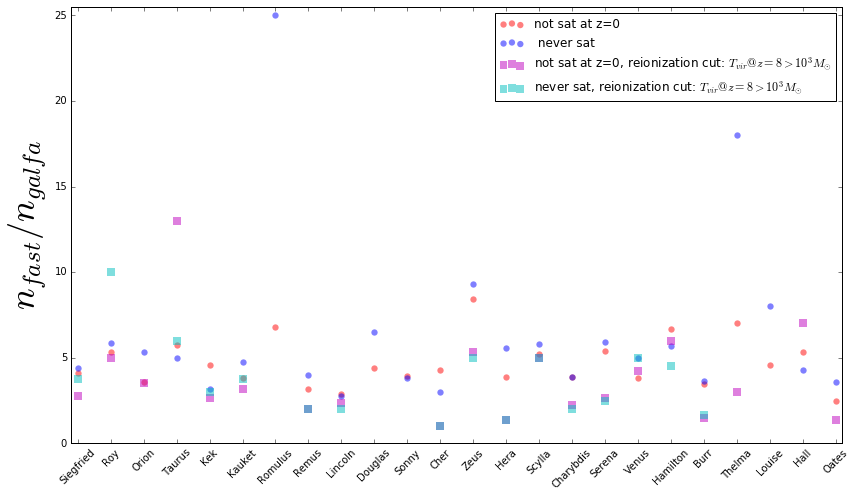

In [151]:
plt.figure(figsize=(12, 7))
plt.scatter(np.arange(len(summary_tab)), summary_tab['nfast/galfa z0'], c='r', lw=0, s=40, alpha=.5, 
            label='not sat at z=0')
plt.scatter(np.arange(len(summary_tab)), summary_tab['nfast/galfa ever'], c='b', lw=0, s=40, alpha=.5, 
            label=' never sat')

plt.scatter(np.arange(len(summary_tab)), summary_tab_re['nfast/galfa z0'], c='m', marker='s', s=60, lw=0, alpha=.5, 
            label='not sat at z=0, reionization cut: $T_{vir}@z=8 > 10^{3} M_{\\odot}$')
plt.scatter(np.arange(len(summary_tab)), summary_tab_re['nfast/galfa ever'], c='c', marker='s', s=60, lw=0, alpha=.5, 
            label='never sat, reionization cut: $T_{vir}@z=8 > 10^{3} M_{\\odot}$')

plt.xlim(-.2, 23.2)
plt.ylim(0,25.5)
plt.ylabel('$n_{fast}/n_{galfa}$', fontsize=36)
plt.xticks(np.arange(len(summary_tab)), list(summary_tab['host name'].astype('U')), rotation=45)
plt.legend(loc=0)
plt.tight_layout()

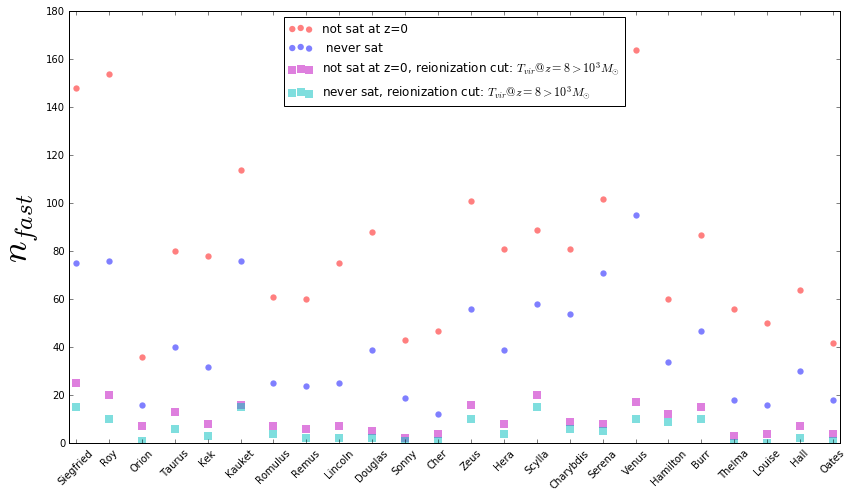

In [152]:
plt.figure(figsize=(12, 7))
plt.scatter(np.arange(len(summary_tab)), summary_tab['nfast z0'], c='r', lw=0, s=40, alpha=.5, 
            label='not sat at z=0')
plt.scatter(np.arange(len(summary_tab)), summary_tab['nfast ever'], c='b', lw=0, s=40, alpha=.5, 
            label=' never sat')

plt.scatter(np.arange(len(summary_tab)), summary_tab_re['nfast z0'], c='m', marker='s', s=60, lw=0, alpha=.5, 
            label='not sat at z=0, reionization cut: $T_{vir}@z=8 > 10^{3} M_{\\odot}$')
plt.scatter(np.arange(len(summary_tab)), summary_tab_re['nfast ever'], c='c', marker='s', s=60, lw=0, alpha=.5, 
            label='never sat, reionization cut: $T_{vir}@z=8 > 10^{3} M_{\\odot}$')

plt.xlim(-.2, 23.2)
plt.ylim(0,180)
plt.ylabel('$n_{fast}$', fontsize=36)
plt.xticks(np.arange(len(summary_tab)), list(summary_tab['host name'].astype('U')), rotation=45)
plt.legend(loc='upper center')
plt.tight_layout()